In [1]:
! pip install transformers

In [2]:
! pip install sentencepiece

In [3]:
from transformers import XLMRobertaForSequenceClassification
from transformers import AdamW
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, TensorDataset

from tqdm import tqdm 
import pandas as pd
import numpy as np
import os
import gc
import random

import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(555)
from sklearn.metrics import precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore")


print(torch.__version__)

2.1.2


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
path = "/kaggle/input/contradictory-my-dear-watson/"


In [6]:
df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

In [7]:
df_train.shape,df_test.shape

((12120, 6), (5195, 5))

In [8]:
df_train.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [9]:
df_test.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64

In [10]:
df_train.duplicated().sum(),df_test.duplicated().sum()

(0, 0)

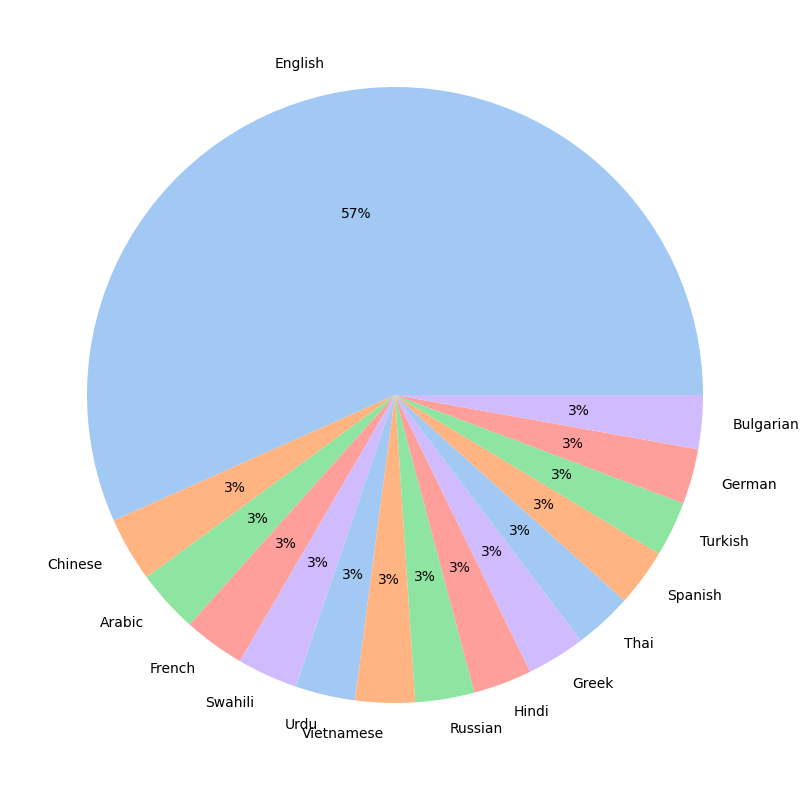

In [11]:
language = (df_train['language'].value_counts()/len(df_train))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
colors = sns.color_palette('pastel')[0:5]
plt.pie(language,labels = language.index,colors = colors, autopct='%.0f%%')
plt.show()

In [13]:
from transformers import TFAutoModel, AutoTokenizer

In [14]:
model_name = 'joeddav/xlm-roberta-large-xnli' 
batch_size = 5
MAX_LENGTH = 256
NUM_EPOCHS = 2
L_RATE = 1e-5
NUM_CORES = os.cpu_count()
NUM_CORES

4

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [16]:
def preprocess(data1, tokenizer):
    kwargs = { 'truncation': True,
    'max_length': MAX_LENGTH,
    'padding': 'max_length',
     'return_attention_mask': True, 
    'return_token_type_ids': True     
    }
    data = list(zip(data1['premise'], data1['hypothesis']))
    tokenized = tokenizer.batch_encode_plus(data,**kwargs)
    input_ids = torch.LongTensor(tokenized.input_ids)
    attention_masks = torch.LongTensor(tokenized.attention_mask)
    token_type_ids = torch.LongTensor(tokenized.token_type_ids)
    return input_ids, attention_masks, token_type_ids

In [17]:
n = len(df_train)
idx = np.array(range(n))
train_idx = np.random.choice(range(n),size = int(n*0.8),replace = False)
valid_idx = idx[np.isin(idx,train_idx)==False]
train_df = df_train.iloc[train_idx].reset_index(drop = True)
valid_df = df_train.iloc[valid_idx].reset_index(drop = True)

In [18]:
input_ids, attention_masks, token_type_ids = preprocess(train_df,tokenizer)
labels = torch.Tensor(train_df['label']).reshape(-1, 1)
train_dataset_final = TensorDataset(input_ids, attention_masks, token_type_ids,labels)
train_dataloader = DataLoader(train_dataset_final, sampler=RandomSampler(train_dataset_final), batch_size=batch_size)
train_dataset_final

In [19]:
print(len(train_dataloader))

1940


In [20]:
input_ids_test, attention_masks_test, token_type_ids_test = preprocess(valid_df,tokenizer)
labels = torch.Tensor(valid_df['label']).reshape(-1, 1)
test_dataset_final = TensorDataset(input_ids_test, attention_masks_test, token_type_ids_test,labels)
test_dataloader = DataLoader(test_dataset_final, sampler=SequentialSampler(test_dataset_final), batch_size=batch_size)
len(test_dataloader)

485

In [21]:
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3, output_hidden_states=False, output_attentions=False,problem_type="multi_label_classification")
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

In [22]:
batch = next(iter(train_dataloader))
b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_token_type_ids = batch[2].to(device)
b_labels = torch.nn.functional.one_hot(batch[3].to(torch.int64), 3).squeeze(1).float().to(device)

In [23]:
outputs = model(b_input_ids, 
                token_type_ids=b_token_type_ids, 
                attention_mask=b_input_mask,
                labels=b_labels)


In [24]:
optimizer = AdamW(model.parameters(),
              lr = L_RATE, 
              eps = 1e-8
            )

In [25]:
gc.collect()

53

In [26]:
seed_val = 1024

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
for epoch in range(NUM_EPOCHS):
    model.train()
    torch.set_grad_enabled(True)
    total_train_loss=0
    
    for i,batch in tqdm(enumerate(train_dataloader)):
#         if i>=200:
#             break
        model.zero_grad()
        input_ids, attention_masks, token_type_ids, labels=(batch[0].to(device), 
                                                            batch[1].to(device), 
                                                            batch[2].to(device), 
                                                            torch.nn.functional.one_hot(batch[3].to(torch.int64), 3).squeeze(1).float().to(device))
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)#, token_type_ids=token_type_ids
        loss=outputs[0]
        if i%10==0:
            print(f'loss of batch {i}: {loss}')
        total_train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

        optimizer.step()
    print(f'total loss of epoch {epoch}: {total_train_loss}')
    gc.collect()

0it [00:00, ?it/s]

loss of batch 0: 2.4002392292022705


10it [00:05,  2.06it/s]

loss of batch 10: 1.0628747940063477


20it [00:09,  2.07it/s]

loss of batch 20: 0.6962907314300537


30it [00:14,  2.07it/s]

loss of batch 30: 0.4711402952671051


40it [00:19,  2.07it/s]

loss of batch 40: 0.3429015874862671


50it [00:24,  2.07it/s]

loss of batch 50: 0.4494175314903259


60it [00:29,  2.07it/s]

loss of batch 60: 0.25214684009552


70it [00:33,  2.07it/s]

loss of batch 70: 0.4800405502319336


80it [00:38,  2.07it/s]

loss of batch 80: 0.1687699258327484


90it [00:43,  2.07it/s]

loss of batch 90: 0.3787212669849396


100it [00:48,  2.07it/s]

loss of batch 100: 0.43307244777679443


110it [00:53,  2.07it/s]

loss of batch 110: 0.2643064260482788


120it [00:58,  2.07it/s]

loss of batch 120: 0.41529032588005066


130it [01:02,  2.07it/s]

loss of batch 130: 0.03645788133144379


140it [01:07,  2.07it/s]

loss of batch 140: 0.21615061163902283


150it [01:12,  2.07it/s]

loss of batch 150: 0.023700648918747902


160it [01:17,  2.07it/s]

loss of batch 160: 0.43838101625442505


170it [01:22,  2.07it/s]

loss of batch 170: 0.028822777792811394


180it [01:27,  2.07it/s]

loss of batch 180: 0.013395661488175392


190it [01:31,  2.07it/s]

loss of batch 190: 0.010913059115409851


200it [01:36,  2.08it/s]

loss of batch 200: 0.42877817153930664


210it [01:41,  2.08it/s]

loss of batch 210: 0.3343636989593506


220it [01:46,  2.08it/s]

loss of batch 220: 2.0502467155456543


230it [01:51,  2.08it/s]

loss of batch 230: 0.7252799868583679


240it [01:55,  2.08it/s]

loss of batch 240: 0.009695049375295639


250it [02:00,  2.07it/s]

loss of batch 250: 0.6367190480232239


260it [02:05,  2.08it/s]

loss of batch 260: 0.01205358374863863


270it [02:10,  2.07it/s]

loss of batch 270: 0.012632879428565502


280it [02:15,  2.07it/s]

loss of batch 280: 0.3434358537197113


290it [02:20,  2.08it/s]

loss of batch 290: 0.7391564846038818


300it [02:24,  2.07it/s]

loss of batch 300: 0.036020684987306595


310it [02:29,  2.07it/s]

loss of batch 310: 0.13735978305339813


320it [02:34,  2.07it/s]

loss of batch 320: 0.6805953979492188


330it [02:39,  2.07it/s]

loss of batch 330: 0.009375547058880329


340it [02:44,  2.07it/s]

loss of batch 340: 0.2053569257259369


350it [02:49,  2.07it/s]

loss of batch 350: 0.4178817868232727


360it [02:53,  2.07it/s]

loss of batch 360: 0.7624416947364807


370it [02:58,  2.07it/s]

loss of batch 370: 0.1401735544204712


380it [03:03,  2.07it/s]

loss of batch 380: 0.007213206496089697


390it [03:08,  2.07it/s]

loss of batch 390: 0.008031156845390797


400it [03:13,  2.07it/s]

loss of batch 400: 0.07756190001964569


410it [03:18,  2.07it/s]

loss of batch 410: 0.04833624139428139


420it [03:22,  2.07it/s]

loss of batch 420: 0.007923658937215805


430it [03:27,  2.07it/s]

loss of batch 430: 0.0067200553603470325


440it [03:32,  2.07it/s]

loss of batch 440: 0.005150316283106804


450it [03:37,  2.07it/s]

loss of batch 450: 0.006795339286327362


460it [03:42,  2.07it/s]

loss of batch 460: 0.006025403272360563


470it [03:46,  2.07it/s]

loss of batch 470: 0.006967008113861084


480it [03:51,  2.07it/s]

loss of batch 480: 0.710663378238678


490it [03:56,  2.07it/s]

loss of batch 490: 0.623892068862915


500it [04:01,  2.07it/s]

loss of batch 500: 0.6385712623596191


510it [04:06,  2.07it/s]

loss of batch 510: 0.0465695895254612


520it [04:11,  2.07it/s]

loss of batch 520: 0.006506087724119425


530it [04:15,  2.07it/s]

loss of batch 530: 0.006232429761439562


540it [04:20,  2.07it/s]

loss of batch 540: 0.6498202085494995


550it [04:25,  2.08it/s]

loss of batch 550: 0.012135706841945648


560it [04:30,  2.07it/s]

loss of batch 560: 0.6166213154792786


570it [04:35,  2.07it/s]

loss of batch 570: 0.011313552968204021


580it [04:40,  2.08it/s]

loss of batch 580: 0.00810539722442627


590it [04:44,  2.08it/s]

loss of batch 590: 1.2931791543960571


600it [04:49,  2.07it/s]

loss of batch 600: 0.4346993863582611


610it [04:54,  2.07it/s]

loss of batch 610: 0.9000462293624878


620it [04:59,  2.07it/s]

loss of batch 620: 0.010671574622392654


630it [05:04,  2.07it/s]

loss of batch 630: 0.4177389442920685


640it [05:08,  2.07it/s]

loss of batch 640: 0.005363938398659229


650it [05:13,  2.07it/s]

loss of batch 650: 1.8268269300460815


660it [05:18,  2.07it/s]

loss of batch 660: 1.1331937313079834


670it [05:23,  2.07it/s]

loss of batch 670: 0.009489383548498154


680it [05:28,  2.07it/s]

loss of batch 680: 0.37032178044319153


690it [05:33,  2.07it/s]

loss of batch 690: 0.6828128099441528


700it [05:37,  2.07it/s]

loss of batch 700: 0.011129360646009445


710it [05:42,  2.07it/s]

loss of batch 710: 0.016246089711785316


720it [05:47,  2.07it/s]

loss of batch 720: 0.5543774962425232


730it [05:52,  2.07it/s]

loss of batch 730: 0.012542207725346088


740it [05:57,  2.07it/s]

loss of batch 740: 0.49701568484306335


750it [06:02,  2.08it/s]

loss of batch 750: 0.006390939466655254


760it [06:06,  2.07it/s]

loss of batch 760: 0.007206846959888935


770it [06:11,  2.07it/s]

loss of batch 770: 0.042474955320358276


780it [06:16,  2.07it/s]

loss of batch 780: 0.6815791130065918


790it [06:21,  2.07it/s]

loss of batch 790: 0.6122192144393921


800it [06:26,  2.07it/s]

loss of batch 800: 0.6893020868301392


810it [06:30,  2.07it/s]

loss of batch 810: 0.004065566696226597


820it [06:35,  2.07it/s]

loss of batch 820: 0.3866254985332489


830it [06:40,  2.07it/s]

loss of batch 830: 0.006248595658689737


840it [06:45,  2.07it/s]

loss of batch 840: 0.6440494656562805


850it [06:50,  2.07it/s]

loss of batch 850: 0.010931000113487244


860it [06:55,  2.07it/s]

loss of batch 860: 0.007408439181745052


870it [06:59,  2.08it/s]

loss of batch 870: 0.013001670129597187


880it [07:04,  2.07it/s]

loss of batch 880: 0.028980622068047523


890it [07:09,  2.07it/s]

loss of batch 890: 0.013930669054389


900it [07:14,  2.07it/s]

loss of batch 900: 0.00654742494225502


910it [07:19,  2.07it/s]

loss of batch 910: 0.0115272868424654


920it [07:24,  2.07it/s]

loss of batch 920: 0.005520552396774292


930it [07:28,  2.07it/s]

loss of batch 930: 0.6947066187858582


940it [07:33,  2.07it/s]

loss of batch 940: 0.5333331227302551


950it [07:38,  2.07it/s]

loss of batch 950: 0.006238225847482681


960it [07:43,  2.07it/s]

loss of batch 960: 0.005960498470813036


970it [07:48,  2.07it/s]

loss of batch 970: 1.2427054643630981


980it [07:52,  2.07it/s]

loss of batch 980: 0.00673097325488925


990it [07:57,  2.07it/s]

loss of batch 990: 0.0044241189025342464


1000it [08:02,  2.07it/s]

loss of batch 1000: 0.022854464128613472


1010it [08:07,  2.07it/s]

loss of batch 1010: 0.15646570920944214


1020it [08:12,  2.07it/s]

loss of batch 1020: 0.004427286330610514


1030it [08:17,  2.07it/s]

loss of batch 1030: 0.4491916000843048


1040it [08:21,  2.07it/s]

loss of batch 1040: 1.8732162714004517


1050it [08:26,  2.07it/s]

loss of batch 1050: 1.0136816501617432


1060it [08:31,  2.07it/s]

loss of batch 1060: 0.6607330441474915


1070it [08:36,  2.07it/s]

loss of batch 1070: 0.0039201462641358376


1080it [08:41,  2.07it/s]

loss of batch 1080: 0.00453540263697505


1090it [08:46,  2.07it/s]

loss of batch 1090: 0.689089834690094


1100it [08:50,  2.07it/s]

loss of batch 1100: 1.2885891199111938


1110it [08:55,  2.07it/s]

loss of batch 1110: 0.00874453503638506


1120it [09:00,  2.07it/s]

loss of batch 1120: 1.2010293006896973


1130it [09:05,  2.07it/s]

loss of batch 1130: 0.009810159914195538


1140it [09:10,  2.07it/s]

loss of batch 1140: 0.48210409283638


1150it [09:15,  2.07it/s]

loss of batch 1150: 0.01732814870774746


1160it [09:19,  2.07it/s]

loss of batch 1160: 0.005626610014587641


1170it [09:24,  2.07it/s]

loss of batch 1170: 0.6002023816108704


1180it [09:29,  2.07it/s]

loss of batch 1180: 0.8963749408721924


1190it [09:34,  2.07it/s]

loss of batch 1190: 0.00844914186745882


1200it [09:39,  2.07it/s]

loss of batch 1200: 0.006822112947702408


1210it [09:44,  2.07it/s]

loss of batch 1210: 0.778242826461792


1220it [09:48,  2.07it/s]

loss of batch 1220: 0.0045082056894898415


1230it [09:53,  2.07it/s]

loss of batch 1230: 0.006892685312777758


1240it [09:58,  2.07it/s]

loss of batch 1240: 0.3177919089794159


1250it [10:03,  2.07it/s]

loss of batch 1250: 0.0037927511148154736


1260it [10:08,  2.07it/s]

loss of batch 1260: 0.011474846862256527


1270it [10:12,  2.07it/s]

loss of batch 1270: 0.7135956287384033


1280it [10:17,  2.07it/s]

loss of batch 1280: 0.05549906939268112


1290it [10:22,  2.07it/s]

loss of batch 1290: 0.006746252533048391


1300it [10:27,  2.07it/s]

loss of batch 1300: 0.30340197682380676


1310it [10:32,  2.07it/s]

loss of batch 1310: 0.013499590568244457


1320it [10:37,  2.07it/s]

loss of batch 1320: 0.0061439406126737595


1330it [10:41,  2.07it/s]

loss of batch 1330: 0.010697359219193459


1340it [10:46,  2.07it/s]

loss of batch 1340: 0.02320307306945324


1350it [10:51,  2.07it/s]

loss of batch 1350: 0.3011379539966583


1360it [10:56,  2.07it/s]

loss of batch 1360: 0.012599170207977295


1370it [11:01,  2.07it/s]

loss of batch 1370: 0.049937985837459564


1380it [11:06,  2.07it/s]

loss of batch 1380: 0.573904275894165


1390it [11:10,  2.07it/s]

loss of batch 1390: 0.5358706712722778


1400it [11:15,  2.07it/s]

loss of batch 1400: 0.010715153068304062


1410it [11:20,  2.07it/s]

loss of batch 1410: 0.012258518487215042


1420it [11:25,  2.07it/s]

loss of batch 1420: 0.27190980315208435


1430it [11:30,  2.07it/s]

loss of batch 1430: 0.0065141357481479645


1440it [11:35,  2.07it/s]

loss of batch 1440: 0.0047430009581148624


1450it [11:39,  2.07it/s]

loss of batch 1450: 0.004998762626200914


1460it [11:44,  2.07it/s]

loss of batch 1460: 0.0063621485605835915


1470it [11:49,  2.07it/s]

loss of batch 1470: 0.7983909845352173


1480it [11:54,  2.07it/s]

loss of batch 1480: 0.5817779302597046


1490it [11:59,  2.07it/s]

loss of batch 1490: 0.2974437475204468


1500it [12:04,  2.07it/s]

loss of batch 1500: 0.20875835418701172


1510it [12:08,  2.07it/s]

loss of batch 1510: 0.5139023065567017


1520it [12:13,  2.07it/s]

loss of batch 1520: 0.004839823115617037


1530it [12:18,  2.07it/s]

loss of batch 1530: 0.36313489079475403


1540it [12:23,  2.07it/s]

loss of batch 1540: 0.0045701623894274235


1550it [12:28,  2.07it/s]

loss of batch 1550: 0.08775942027568817


1560it [12:32,  2.07it/s]

loss of batch 1560: 0.006591417361050844


1570it [12:37,  2.07it/s]

loss of batch 1570: 0.19739893078804016


1580it [12:42,  2.07it/s]

loss of batch 1580: 0.18025724589824677


1590it [12:47,  2.07it/s]

loss of batch 1590: 0.7469401955604553


1600it [12:52,  2.07it/s]

loss of batch 1600: 0.509666919708252


1610it [12:57,  2.07it/s]

loss of batch 1610: 0.02104126289486885


1620it [13:01,  2.07it/s]

loss of batch 1620: 0.006779382470995188


1630it [13:06,  2.07it/s]

loss of batch 1630: 0.005030693020671606


1640it [13:11,  2.07it/s]

loss of batch 1640: 0.01962658204138279


1650it [13:16,  2.07it/s]

loss of batch 1650: 0.03278164193034172


1660it [13:21,  2.07it/s]

loss of batch 1660: 0.5206190943717957


1670it [13:26,  2.07it/s]

loss of batch 1670: 0.5122466683387756


1680it [13:30,  2.07it/s]

loss of batch 1680: 0.03939208760857582


1690it [13:35,  2.07it/s]

loss of batch 1690: 0.006649889051914215


1700it [13:40,  2.07it/s]

loss of batch 1700: 1.82952082157135


1710it [13:45,  2.07it/s]

loss of batch 1710: 0.043267183005809784


1720it [13:50,  2.07it/s]

loss of batch 1720: 0.3775734603404999


1730it [13:55,  2.07it/s]

loss of batch 1730: 0.7102758288383484


1740it [13:59,  2.07it/s]

loss of batch 1740: 0.02222357504069805


1750it [14:04,  2.07it/s]

loss of batch 1750: 0.09513705968856812


1760it [14:09,  2.07it/s]

loss of batch 1760: 0.0030107987113296986


1770it [14:14,  2.07it/s]

loss of batch 1770: 0.020229006186127663


1780it [14:19,  2.07it/s]

loss of batch 1780: 0.5850207209587097


1790it [14:24,  2.07it/s]

loss of batch 1790: 0.023971738293766975


1800it [14:28,  2.07it/s]

loss of batch 1800: 0.008561008609831333


1810it [14:33,  2.07it/s]

loss of batch 1810: 0.007917463779449463


1820it [14:38,  2.07it/s]

loss of batch 1820: 0.04277339577674866


1830it [14:43,  2.07it/s]

loss of batch 1830: 0.024159276857972145


1840it [14:48,  2.07it/s]

loss of batch 1840: 0.5584489703178406


1850it [14:53,  2.07it/s]

loss of batch 1850: 0.014808287844061852


1860it [14:57,  2.07it/s]

loss of batch 1860: 0.004465694539248943


1870it [15:02,  2.07it/s]

loss of batch 1870: 0.517375111579895


1880it [15:07,  2.07it/s]

loss of batch 1880: 0.6712843775749207


1890it [15:12,  2.07it/s]

loss of batch 1890: 0.038172073662281036


1900it [15:17,  2.07it/s]

loss of batch 1900: 0.01163062546402216


1910it [15:22,  2.07it/s]

loss of batch 1910: 0.7513248324394226


1920it [15:26,  2.07it/s]

loss of batch 1920: 0.003998648375272751


1930it [15:31,  2.07it/s]

loss of batch 1930: 0.5377755761146545


1940it [15:36,  2.07it/s]


total loss of epoch 0: 582.8490567512345


0it [00:00, ?it/s]

loss of batch 0: 0.6019617319107056


10it [00:04,  2.07it/s]

loss of batch 10: 0.007556907366961241


20it [00:09,  2.07it/s]

loss of batch 20: 0.005275675095617771


30it [00:14,  2.07it/s]

loss of batch 30: 0.5654425024986267


40it [00:19,  2.07it/s]

loss of batch 40: 0.0037578013725578785


50it [00:24,  2.07it/s]

loss of batch 50: 0.779697597026825


60it [00:28,  2.07it/s]

loss of batch 60: 0.0033675022423267365


70it [00:33,  2.07it/s]

loss of batch 70: 0.0031413224060088396


80it [00:38,  2.07it/s]

loss of batch 80: 0.003741422202438116


90it [00:43,  2.07it/s]

loss of batch 90: 0.005245193839073181


100it [00:48,  2.07it/s]

loss of batch 100: 0.0025585428811609745


110it [00:53,  2.07it/s]

loss of batch 110: 0.0023429812863469124


120it [00:57,  2.07it/s]

loss of batch 120: 0.008660893887281418


130it [01:02,  2.07it/s]

loss of batch 130: 0.0018314861226826906


140it [01:07,  2.07it/s]

loss of batch 140: 0.002800756599754095


150it [01:12,  2.07it/s]

loss of batch 150: 0.7871120572090149


160it [01:17,  2.07it/s]

loss of batch 160: 0.4000726640224457


170it [01:22,  2.07it/s]

loss of batch 170: 0.4556414783000946


180it [01:26,  2.07it/s]

loss of batch 180: 0.002779607428237796


190it [01:31,  2.07it/s]

loss of batch 190: 0.004487290512770414


200it [01:36,  2.07it/s]

loss of batch 200: 0.6177306771278381


210it [01:41,  2.07it/s]

loss of batch 210: 0.002867097733542323


220it [01:46,  2.07it/s]

loss of batch 220: 0.6857815384864807


230it [01:51,  2.07it/s]

loss of batch 230: 0.00547223724424839


240it [01:55,  2.07it/s]

loss of batch 240: 0.005992562975734472


250it [02:00,  2.07it/s]

loss of batch 250: 0.6933644413948059


260it [02:05,  2.07it/s]

loss of batch 260: 0.37740206718444824


270it [02:10,  2.07it/s]

loss of batch 270: 0.0021745488047599792


280it [02:15,  2.07it/s]

loss of batch 280: 0.0028259018436074257


290it [02:20,  2.07it/s]

loss of batch 290: 0.002776823006570339


300it [02:24,  2.07it/s]

loss of batch 300: 0.6220428943634033


310it [02:29,  2.07it/s]

loss of batch 310: 0.03396083042025566


320it [02:34,  2.07it/s]

loss of batch 320: 0.003181260311976075


330it [02:39,  2.07it/s]

loss of batch 330: 0.00386977125890553


340it [02:44,  2.07it/s]

loss of batch 340: 0.003640662180259824


350it [02:49,  2.07it/s]

loss of batch 350: 0.0024301535449922085


360it [02:53,  2.07it/s]

loss of batch 360: 0.0034260523971170187


370it [02:58,  2.07it/s]

loss of batch 370: 0.0050673708319664


380it [03:03,  2.07it/s]

loss of batch 380: 0.0027555900160223246


390it [03:08,  2.07it/s]

loss of batch 390: 0.0034865872003138065


400it [03:13,  2.07it/s]

loss of batch 400: 0.002667453605681658


410it [03:18,  2.07it/s]

loss of batch 410: 0.3111107647418976


420it [03:22,  2.07it/s]

loss of batch 420: 0.8240371346473694


430it [03:27,  2.07it/s]

loss of batch 430: 0.0047612800262868404


440it [03:32,  2.07it/s]

loss of batch 440: 0.009141974151134491


450it [03:37,  2.07it/s]

loss of batch 450: 0.06741732358932495


460it [03:42,  2.07it/s]

loss of batch 460: 0.0029387332033365965


470it [03:47,  2.07it/s]

loss of batch 470: 0.002773190615698695


480it [03:51,  2.07it/s]

loss of batch 480: 0.14412224292755127


490it [03:56,  2.07it/s]

loss of batch 490: 0.07876495271921158


500it [04:01,  2.07it/s]

loss of batch 500: 0.005778868682682514


510it [04:06,  2.07it/s]

loss of batch 510: 0.004295422695577145


520it [04:11,  2.07it/s]

loss of batch 520: 0.0031464220955967903


530it [04:16,  2.07it/s]

loss of batch 530: 0.001978339860215783


540it [04:20,  2.07it/s]

loss of batch 540: 0.16532768309116364


550it [04:25,  2.07it/s]

loss of batch 550: 0.004545519594103098


560it [04:30,  2.07it/s]

loss of batch 560: 0.0015496121486648917


570it [04:35,  2.07it/s]

loss of batch 570: 0.0018178598256781697


580it [04:40,  2.07it/s]

loss of batch 580: 0.0020041458774358034


590it [04:45,  2.07it/s]

loss of batch 590: 0.006777704693377018


600it [04:49,  2.07it/s]

loss of batch 600: 0.7729406952857971


610it [04:54,  2.07it/s]

loss of batch 610: 0.0067136394791305065


620it [04:59,  2.07it/s]

loss of batch 620: 0.0025530392304062843


630it [05:04,  2.07it/s]

loss of batch 630: 0.005004445556551218


640it [05:09,  2.07it/s]

loss of batch 640: 0.7500371932983398


650it [05:14,  2.07it/s]

loss of batch 650: 0.34907960891723633


660it [05:18,  2.07it/s]

loss of batch 660: 0.008646328933537006


670it [05:23,  2.07it/s]

loss of batch 670: 0.0022657678928226233


680it [05:28,  2.07it/s]

loss of batch 680: 0.0026983018033206463


690it [05:33,  2.07it/s]

loss of batch 690: 0.0032661734148859978


700it [05:38,  2.07it/s]

loss of batch 700: 0.00375542463734746


710it [05:43,  2.07it/s]

loss of batch 710: 0.002077853074297309


720it [05:47,  2.07it/s]

loss of batch 720: 0.571687638759613


730it [05:52,  2.07it/s]

loss of batch 730: 0.0016671543708071113


740it [05:57,  2.07it/s]

loss of batch 740: 0.002103051170706749


750it [06:02,  2.07it/s]

loss of batch 750: 0.0018816670635715127


760it [06:07,  2.07it/s]

loss of batch 760: 0.001957283355295658


770it [06:12,  2.07it/s]

loss of batch 770: 0.002169380197301507


780it [06:16,  2.07it/s]

loss of batch 780: 0.003403410781174898


790it [06:21,  2.07it/s]

loss of batch 790: 1.2250676155090332


800it [06:26,  2.07it/s]

loss of batch 800: 0.0020819734781980515


810it [06:31,  2.07it/s]

loss of batch 810: 0.6930025815963745


820it [06:36,  2.07it/s]

loss of batch 820: 0.0018091299571096897


830it [06:41,  2.07it/s]

loss of batch 830: 0.09389239549636841


840it [06:45,  2.07it/s]

loss of batch 840: 0.002062498824670911


850it [06:50,  2.07it/s]

loss of batch 850: 0.6306246519088745


860it [06:55,  2.07it/s]

loss of batch 860: 0.0018020507413893938


870it [07:00,  2.07it/s]

loss of batch 870: 0.0019423438934609294


880it [07:05,  2.07it/s]

loss of batch 880: 0.001454349490813911


890it [07:10,  2.07it/s]

loss of batch 890: 0.0017408850835636258


900it [07:14,  2.07it/s]

loss of batch 900: 0.002092882990837097


910it [07:19,  2.07it/s]

loss of batch 910: 0.0017638899153098464


920it [07:24,  2.07it/s]

loss of batch 920: 0.5653974413871765


930it [07:29,  2.07it/s]

loss of batch 930: 0.0031462532933801413


940it [07:34,  2.07it/s]

loss of batch 940: 0.0013784535694867373


950it [07:39,  2.07it/s]

loss of batch 950: 0.7848662734031677


960it [07:43,  2.07it/s]

loss of batch 960: 0.0022975171450525522


970it [07:48,  2.07it/s]

loss of batch 970: 0.0018474779790267348


980it [07:53,  2.07it/s]

loss of batch 980: 0.0014861831441521645


990it [07:58,  2.07it/s]

loss of batch 990: 0.0012821361888200045


1000it [08:03,  2.07it/s]

loss of batch 1000: 0.34189072251319885


1010it [08:08,  2.07it/s]

loss of batch 1010: 0.0020561772398650646


1020it [08:12,  2.07it/s]

loss of batch 1020: 0.8119454383850098


1030it [08:17,  2.07it/s]

loss of batch 1030: 0.6924998760223389


1040it [08:22,  2.07it/s]

loss of batch 1040: 0.0017812777077779174


1050it [08:27,  2.07it/s]

loss of batch 1050: 0.002078915247693658


1060it [08:32,  2.07it/s]

loss of batch 1060: 0.0012345921713858843


1070it [08:37,  2.07it/s]

loss of batch 1070: 0.0018275106558576226


1080it [08:41,  2.07it/s]

loss of batch 1080: 0.010366830043494701


1090it [08:46,  2.07it/s]

loss of batch 1090: 0.9195652604103088


1100it [08:51,  2.07it/s]

loss of batch 1100: 1.5307213068008423


1110it [08:56,  2.07it/s]

loss of batch 1110: 0.2617420554161072


1120it [09:01,  2.07it/s]

loss of batch 1120: 0.005256941542029381


1130it [09:06,  2.07it/s]

loss of batch 1130: 0.003062043571844697


1140it [09:10,  2.07it/s]

loss of batch 1140: 0.001634235610254109


1150it [09:15,  2.07it/s]

loss of batch 1150: 1.4999643564224243


1160it [09:20,  2.07it/s]

loss of batch 1160: 0.2740619480609894


1170it [09:25,  2.07it/s]

loss of batch 1170: 0.0016659293323755264


1180it [09:30,  2.07it/s]

loss of batch 1180: 0.0016192988259717822


1190it [09:35,  2.07it/s]

loss of batch 1190: 0.0012857281835749745


1200it [09:39,  2.07it/s]

loss of batch 1200: 0.823424220085144


1210it [09:44,  2.07it/s]

loss of batch 1210: 0.6973918676376343


1220it [09:49,  2.07it/s]

loss of batch 1220: 0.0017270303796976805


1230it [09:54,  2.07it/s]

loss of batch 1230: 0.0033795980270951986


1240it [09:59,  2.07it/s]

loss of batch 1240: 0.7596771121025085


1250it [10:04,  2.07it/s]

loss of batch 1250: 0.005097025539726019


1260it [10:08,  2.07it/s]

loss of batch 1260: 0.821528434753418


1270it [10:13,  2.07it/s]

loss of batch 1270: 0.0019659942481666803


1280it [10:18,  2.07it/s]

loss of batch 1280: 0.02265864796936512


1290it [10:23,  2.07it/s]

loss of batch 1290: 0.6021639108657837


1300it [10:28,  2.07it/s]

loss of batch 1300: 0.9496027827262878


1310it [10:33,  2.07it/s]

loss of batch 1310: 0.392951637506485


1320it [10:38,  2.07it/s]

loss of batch 1320: 0.002200301503762603


1330it [10:42,  2.07it/s]

loss of batch 1330: 0.7946105003356934


1340it [10:47,  2.07it/s]

loss of batch 1340: 0.0016887051751837134


1350it [10:52,  2.07it/s]

loss of batch 1350: 0.8188498020172119


1360it [10:57,  2.07it/s]

loss of batch 1360: 0.6472482085227966


1370it [11:02,  2.07it/s]

loss of batch 1370: 0.7076343894004822


1380it [11:07,  2.07it/s]

loss of batch 1380: 0.0021684204693883657


1390it [11:11,  2.07it/s]

loss of batch 1390: 0.009840684942901134


1400it [11:16,  2.07it/s]

loss of batch 1400: 0.002540630754083395


1410it [11:21,  2.07it/s]

loss of batch 1410: 0.0054538073018193245


1420it [11:26,  2.07it/s]

loss of batch 1420: 0.09935534745454788


1430it [11:31,  2.07it/s]

loss of batch 1430: 0.0038455529138445854


1440it [11:36,  2.07it/s]

loss of batch 1440: 0.003666952019557357


1450it [11:40,  2.07it/s]

loss of batch 1450: 0.6870443820953369


1460it [11:45,  2.07it/s]

loss of batch 1460: 0.7529595494270325


1470it [11:50,  2.07it/s]

loss of batch 1470: 0.00192537612747401


1480it [11:55,  2.07it/s]

loss of batch 1480: 0.002913510426878929


1490it [12:00,  2.07it/s]

loss of batch 1490: 0.6809406876564026


1500it [12:05,  2.07it/s]

loss of batch 1500: 0.0027387829031795263


1510it [12:09,  2.07it/s]

loss of batch 1510: 0.003496910911053419


1520it [12:14,  2.07it/s]

loss of batch 1520: 0.002966211410239339


1530it [12:19,  2.07it/s]

loss of batch 1530: 0.7374646067619324


1540it [12:24,  2.07it/s]

loss of batch 1540: 0.001963017974048853


1550it [12:29,  2.07it/s]

loss of batch 1550: 0.7017077207565308


1560it [12:34,  2.07it/s]

loss of batch 1560: 0.002737819217145443


1570it [12:38,  2.07it/s]

loss of batch 1570: 0.003496276680380106


1580it [12:43,  2.07it/s]

loss of batch 1580: 0.23669922351837158


1590it [12:48,  2.07it/s]

loss of batch 1590: 0.005418059416115284


1600it [12:53,  2.07it/s]

loss of batch 1600: 0.1527576744556427


1610it [12:58,  2.07it/s]

loss of batch 1610: 0.7022255063056946


1620it [13:03,  2.07it/s]

loss of batch 1620: 0.0038745785132050514


1630it [13:07,  2.07it/s]

loss of batch 1630: 0.47697749733924866


1640it [13:12,  2.07it/s]

loss of batch 1640: 0.003907331265509129


1650it [13:17,  2.07it/s]

loss of batch 1650: 0.582732617855072


1660it [13:22,  2.07it/s]

loss of batch 1660: 0.02556493878364563


1670it [13:27,  2.07it/s]

loss of batch 1670: 0.005002851597964764


1680it [13:32,  2.07it/s]

loss of batch 1680: 0.002526594325900078


1690it [13:36,  2.07it/s]

loss of batch 1690: 0.0025662339758127928


1700it [13:41,  2.07it/s]

loss of batch 1700: 0.004056158475577831


1710it [13:46,  2.07it/s]

loss of batch 1710: 0.0031111440621316433


1720it [13:51,  2.07it/s]

loss of batch 1720: 0.046206552535295486


1730it [13:56,  2.07it/s]

loss of batch 1730: 1.6596311330795288


1740it [14:01,  2.07it/s]

loss of batch 1740: 0.17169040441513062


1750it [14:05,  2.07it/s]

loss of batch 1750: 0.8367677330970764


1760it [14:10,  2.07it/s]

loss of batch 1760: 0.0020368769764900208


1770it [14:15,  2.07it/s]

loss of batch 1770: 0.003757722908630967


1780it [14:20,  2.07it/s]

loss of batch 1780: 0.0037736042868345976


1790it [14:25,  2.07it/s]

loss of batch 1790: 0.8823963403701782


1800it [14:30,  2.07it/s]

loss of batch 1800: 0.002400975441560149


1810it [14:34,  2.07it/s]

loss of batch 1810: 0.6642411947250366


1820it [14:39,  2.07it/s]

loss of batch 1820: 0.004196898080408573


1830it [14:44,  2.07it/s]

loss of batch 1830: 0.002703500911593437


1840it [14:49,  2.07it/s]

loss of batch 1840: 0.0031256885267794132


1850it [14:54,  2.07it/s]

loss of batch 1850: 0.0025374034885317087


1860it [14:59,  2.07it/s]

loss of batch 1860: 0.731048583984375


1870it [15:03,  2.07it/s]

loss of batch 1870: 1.4075217247009277


1880it [15:08,  2.07it/s]

loss of batch 1880: 0.002250181045383215


1890it [15:13,  2.07it/s]

loss of batch 1890: 0.004010896664112806


1900it [15:18,  2.07it/s]

loss of batch 1900: 0.32205474376678467


1910it [15:23,  2.07it/s]

loss of batch 1910: 0.002553648315370083


1920it [15:28,  2.07it/s]

loss of batch 1920: 0.021825894713401794


1930it [15:32,  2.07it/s]

loss of batch 1930: 0.002145967446267605


1940it [15:37,  2.07it/s]


total loss of epoch 1: 391.23021142708603


In [28]:
stacked_val_labels = []
true_labels = []
model.eval()

torch.set_grad_enabled(False)
total_val_loss = 0

for j, batch in enumerate(test_dataloader):
    input_ids, attention_masks, token_type_ids,labels=(batch[0].to(device), 
                                                        batch[1].to(device), 
                                                        batch[2].to(device),
                                                torch.nn.functional.one_hot(batch[3].to(torch.int64), 3).squeeze(1).float().to(device))
    #print(input_ids.shape, token_type_ids.shape, attention_masks.shape)
    outputs = model(input_ids, attention_mask=attention_masks,labels = labels) #, token_type_ids=token_type_ids

    loss = outputs.loss
    logits = outputs.logits
    true = batch[3]

    val_preds = logits.detach().cpu().numpy()
#     print(val_preds)
    total_val_loss += loss.item()
    if j == 0:  # first batch
        stacked_val_preds = val_preds
        true_labels = true

    else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
        true_labels = np.vstack((true_labels, true))
        #stacked_val_preds.extend(val_preds)
    #print(len(stacked_val_preds))

    
            
print(f'\nPrediction complete.\nAverage loss: {total_val_loss/len(test_dataset_final)}')



Prediction complete.
Average loss: 0.07389216565190071


In [29]:
test_preds = np.argmax(stacked_val_preds, axis=1)

In [30]:
test_preds

array([0, 0, 1, ..., 2, 1, 0])

In [31]:
true = true_labels.flatten().astype('int64')

In [32]:
acc = np.sum(test_preds == true)/len(test_preds)
acc

0.8865511551155115

In [33]:
precision, recall, fscore, support = precision_recall_fscore_support(true, test_preds)

In [34]:
score_data = []
for i,(p,r,f,s) in enumerate(zip(precision, recall, fscore, support)):
      score_data.append((i,p,r,f,s))

In [35]:
df = pd.DataFrame(score_data,columns=['label','precision','recall','fscore','support'])

In [36]:
df

,label,precision,recall,fscore,support
0,0,0.861726,0.938554,0.898501,830
1,1,0.887989,0.832911,0.859569,790
2,2,0.913992,0.885572,0.899558,804


In [37]:
print(b_input_ids, b_input_mask, b_token_type_ids, b_labels)

tensor([[    0, 97250,   597,  ...,     1,     1,     1],
        [    0,   717,  2363,  ...,     1,     1,     1],
        [    0,   360,    70,  ...,     1,     1,     1],
        [    0,  4619,  1145,  ...,     1,     1,     1],
        [    0,  1650,  1556,  ...,     1,     1,     1]], device='cuda:0') tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0') tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0') tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]], device='cuda:0')


In [38]:
# for j, batch in enumerate(test_dataloader):
#     input_ids, attention_masks, token_type_ids,labels=(batch[0].to(device), 
#                                                         batch[1].to(device), 
#                                                         batch[2].to(device),
#                                                 torch.nn.functional.one_hot(batch[3].to(torch.int64), 3).squeeze(1).float().to(device))
#     print(input_ids[0].shape, attention_masks[0].shape, token_type_ids[0].shape,labels[0].shape)

In [39]:
input_ids_, token_type_ids_, attention_masks_ = preprocess(
    {
        "premise":["I am not happy."],
        "hypothesis":["I am happy."]
    }
,tokenizer)

# device = "cuda"

# model = model.to(device)

print(input_ids_.shape, token_type_ids_.shape, attention_masks_.shape)

model.eval()
with torch.no_grad():
    outputs = model(input_ids_.to(device), attention_mask=attention_masks_.to(device))
    logits = outputs.logits

# Get predictions
print(logits)
predictions = torch.argmax(logits, dim=-1)
predicted_labels = predictions.cpu().numpy().tolist()
predicted_labels

torch.Size([1, 256]) torch.Size([1, 256]) torch.Size([1, 256])
tensor([[-3.1253, -7.3759,  3.3658]], device='cuda:0')


[2]

In [40]:
save_directory = "./fine_tuned_model"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/sentencepiece.bpe.model',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

In [43]:
!zip -r fine_tuned_model.zip /kaggle/working/fine_tuned_model 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


updating: kaggle/working/fine_tuned_model/ (stored 0%)
updating: kaggle/working/fine_tuned_model/model.safetensors (deflated 14%)
updating: kaggle/working/fine_tuned_model/sentencepiece.bpe.model (deflated 49%)
updating: kaggle/working/fine_tuned_model/special_tokens_map.json (deflated 52%)
updating: kaggle/working/fine_tuned_model/config.json (deflated 51%)
updating: kaggle/working/fine_tuned_model/tokenizer.json (deflated 76%)
updating: kaggle/working/fine_tuned_model/tokenizer_config.json (deflated 76%)


In [45]:
from IPython.display import FileLink
FileLink(r'fine_tuned_model.zip')

/kaggle/working/fine_tuned_model.zip